In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# On a un dataset en 3 .csv, qui n'ont pas le même nombre de colonnes ni le même nom de colonnes.
# On veut les concaténer en un seul .csv

df18 = pd.read_csv('Data_2018.csv')
df19 = pd.read_csv('Data_2019.csv')
df20 = pd.read_csv('Data_2020.csv')

In [3]:
# df18.columns
# ['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
#        'season', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
#        'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR', 'Classification', 'RSC  meq  / L',
#        'Classification.1']

# df19.columns
# ['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
#        'season', 'pH', 'EC', 'TDS', 'CO_-2 ', 'HCO_ - ', 'Cl -', 'F -',
#        'NO3- ', 'SO4-2', 'Na+', 'K+', 'Ca+2', 'Mg+2', 'T.H', 'SAR',
#        'Classification', 'RSC  meq  / L', 'Classification.1']

# df20.columns
# ['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
#        'season', 'Unnamed: 8', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3', 'Cl', 'F',
#        'NO3 ', 'SO4', 'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR', 'Classification',
#        'RSC  meq  / L', 'Classification.1']

In [4]:
# df20 a une colonne de plus que df18 et df19.

# df20['Unnamed: 8'].unique()

# ce ne sont que des NaN, on peut donc la supprimer
df20.drop(columns=['Unnamed: 8'], inplace=True)

In [5]:
# changer le nom des colonnes de df19 et df20 pour qu'ils soit identiques à df18

df19 = df19.rename(columns=dict(zip(df19.columns, df18.columns)))
df20 = df20.rename(columns=dict(zip(df20.columns, df18.columns)))

# vérifier que les colonnes sont identiques
for i in df18.columns:
    if i not in df19.columns:
        print(i)
    if i not in df20.columns:
        print(i)

In [6]:
# On peut concaténer les 3 dataframes en un seul
df_concat = pd.concat([df18, df19, df20], ignore_index=True)

df = df_concat.copy()

df.shape

(1106, 26)

In [7]:
# df.shape
# df.info()
# df.head()
# df.describe()
# df.dtypes
# df.tail()
# df.columns
df.isnull().sum()

sno                   0
district              0
mandal                0
village               0
lat_gis               0
long_gis              0
gwl                  11
season                0
pH                    0
E.C                   0
TDS                   0
CO3                 160
HCO3                  0
Cl                    0
F                     0
NO3                   0
SO4                   0
Na                    0
K                     0
Ca                    0
Mg                    0
T.H                   0
SAR                   0
Classification        0
RSC  meq  / L         0
Classification.1      0
dtype: int64

In [8]:
# On remarque que df['pH'] apparait comme un objet, mais il s'agit surement d'une variable numérique

# df['pH'].unique()
for i in df['pH'].unique():
    try:
        float(i)
    except:
        print(i)

8..05


In [9]:
# df[df['pH'] == '8..05']
df['pH'] = df['pH'].replace('8..05', '8.05')

# Maintenant, on peut convertir la colonne en float
# Convert the values in the 'pH' column to float and coerce non-numeric values to NaN
df['pH'] = pd.to_numeric(df['pH'], errors='coerce')
df['pH'].dtype

dtype('float64')

In [10]:
# La variable cible est df["Classification"]
# il faut l'encoder
# C2S1 le reformuler comme Moderate
# C3S1 le reformuler comme Poor
# C4S2 le reformuler comme Bad
# C4S1 le reformuler comme Bad
# C3S2 le reformuler comme Poor
# C4S4 le reformuler comme Bad
# C4S3 le reformuler comme Bad
# C1S1 le reformuler comme Good
# C3S4 le reformuler comme Bad
# C3S3 le reformuler comme Poor
# C2S2 le reformuler comme Moderate
# Supprimer les lignes pour les autres targets

In [11]:
df['Classification'].unique()

array(['C2S1', 'C3S1', 'C4S2', 'C4S1', 'C3S2', 'C4S4', 'C4S3', 'C1S1',
       'C3S4', 'C3S3', 'C2S2', 'OG', 'O.G'], dtype=object)

In [12]:
# drop les lignes qui ont des valeurs == 'OG' ou 'O.G' dans la colonne df['Classification']
df = df[df['Classification'] != 'OG']
df = df[df['Classification'] != 'O.G']

# changer les valeurs par les catégories Poor, Bad, Moderate, Good
df['Classification'] = df['Classification'].replace({
    'C2S1': 'Moderate',
    'C3S1': 'Poor',
    'C4S2': 'Bad',
    'C4S1': 'Bad',
    'C3S2': 'Poor',
    'C4S4': 'Bad',
    'C4S3': 'Bad',
    'C1S1': 'Good',
    'C3S4': 'Bad',
    'C3S3': 'Poor',
    'C2S2': 'Moderate'
})

df['Classification'].value_counts()

Classification
Poor        714
Moderate    249
Bad         136
Good          3
Name: count, dtype: int64

In [13]:
le = LabelEncoder()
df['Classification'] = le.fit_transform(df['Classification'])
df['Classification'].value_counts()

Classification
3    714
2    249
0    136
1      3
Name: count, dtype: int64

In [14]:
# Quelles sont les variables les plus corrélées avec la variable cible ?
df_corr_test = df.drop(['sno', 'district', 'mandal', 'season', 'village', 'Classification.1'], axis=1)

# Calcul de la matrice de corrélation et affichage des 10 variables les plus corrélées avec la variable cible
corr_matrix = df_corr_test.corr()[['Classification']]
corr_matrix.abs().sort_values(by='Classification', ascending=False).head(11).index

Index(['Classification', 'Cl', 'TDS', 'E.C', 'Na', 'T.H', 'NO3 ', 'Mg',
       'RSC  meq  / L', 'Ca', 'SAR'],
      dtype='object')

In [15]:
# Drop toutes les colonnes qui ne sont pas nommée ['E.C', 'TDS', 'Cl', 'NO3 ', 'Na', 'Ca', 'Mg', 'T.H', 'SAR', 'RSC  meq  / L', 'Classification']
df = df.drop(columns=df.columns.difference(['E.C', 'TDS', 'Cl', 'NO3 ', 'Na', 'Ca', 'Mg', 'T.H', 'SAR', 'RSC  meq  / L', 'Classification']))
df.columns

Index(['E.C', 'TDS', 'Cl', 'NO3 ', 'Na', 'Ca', 'Mg', 'T.H', 'SAR',
       'Classification', 'RSC  meq  / L'],
      dtype='object')

In [16]:
# Selectionne les lignes dupliquées
duplicated = df[df.duplicated(keep=False)]
duplicated

,E.C,TDS,Cl,NO3,Na,Ca,Mg,T.H,SAR,Classification,RSC meq / L
248,1778,1137.92,300,122.683300,121.990758,152.0,48.620,579.917763,2.202500,3,-5.080797
257,1778,1137.92,300,122.683300,121.990758,152.0,48.620,579.917763,2.202500,3,-5.080797
467,1414,904.96,160,73.078500,96.000000,112.0,63.206,539.893092,1.796344,3,-2.197862
472,1235,790.40,140,68.649500,70.500000,96.0,68.068,519.884868,1.344336,3,-3.197697
474,1126,720.64,130,26.574000,55.000000,96.0,53.482,459.909539,1.115061,3,-1.998191
476,1120,716.80,120,13.419870,118.500000,64.0,38.896,319.934211,2.880449,3,0.801316
612,1123,718.72,260,150.586000,120.000000,88.0,19.448,299.967105,3.012427,3,-4.799342
621,1123,718.72,260,150.586000,120.000000,88.0,19.448,299.967105,3.012427,3,-4.799342
634,1126,720.64,130,26.574000,55.000000,96.0,53.482,459.909539,1.115061,3,-1.998191
639,1235,790.40,140,68.649500,70.500000,96.0,68.068,519.884868,1.344336,3,-3.197697


In [17]:
# drop the duplicates from df
df = df.drop_duplicates()

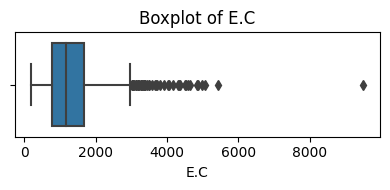

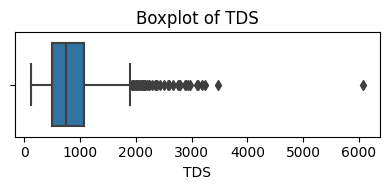

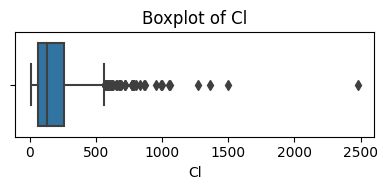

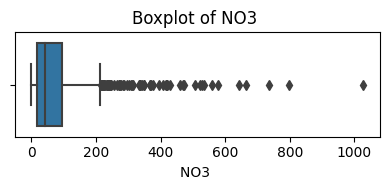

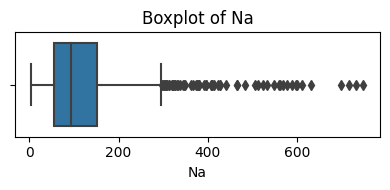

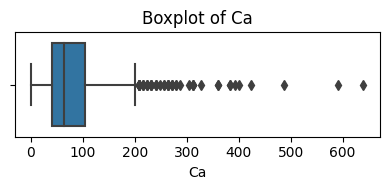

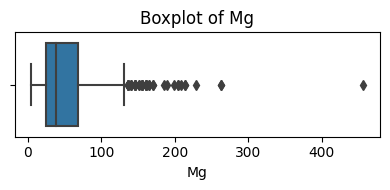

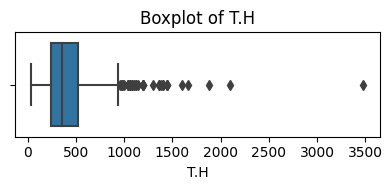

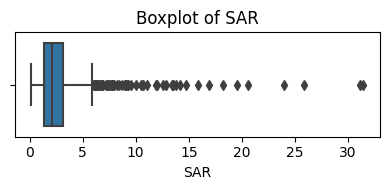

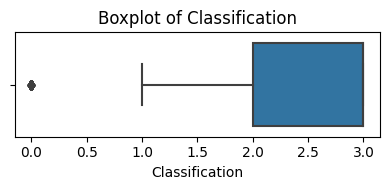

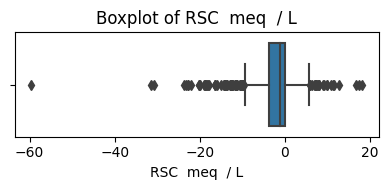

In [18]:
# On peut maintenant s'occuper des valeurs abérentes.
# On va remplacer les outliers par nan puis probablement les imputer avec KNNImputer.

# Create separate boxplots for each feature
for column in df:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

In [19]:
# J'ai cherché des outliers dans toutes les colonnes y compris 'Classification' 
# mais dans les outliers de Classification sont tous et uniquement les 136 'bad'
# donc j'identifie les outliers dans tout df sauf la target

def replace_outliers(df):
    """Replace outliers in df with np.nan"""
    for col in df.columns:
        if col != 'Classification':
            q1, q3 = df[col].quantile([0.25, 0.75])
            iqr = q3 - q1

            upper_bound = q3 + 1.5 * iqr
            lower_bound = q1 - 1.5 * iqr

            df.loc[df[col] < lower_bound, col] = np.nan
            df.loc[df[col] > upper_bound, col] = np.nan

    return df

In [20]:
df = replace_outliers(df)

df.isna().sum()

E.C               46
TDS               46
Cl                48
NO3               75
Na                64
Ca                48
Mg                41
T.H               39
SAR               66
Classification     0
RSC  meq  / L     87
dtype: int64

In [21]:
# drop les lignes qui ont des valeurs manquantes dans la colonne 'Classification'

df = df.dropna(subset=['Classification'])

In [22]:
def impute_missing_values_knn(df):
    imputer = KNNImputer(n_neighbors=5)
    for col in df.columns:
        df[[col]] = imputer.fit_transform(df[[col]])
    return df

In [23]:
df = impute_missing_values_knn(df)

df.isnull().sum()

E.C               0
TDS               0
Cl                0
NO3               0
Na                0
Ca                0
Mg                0
T.H               0
SAR               0
Classification    0
RSC  meq  / L     0
dtype: int64

In [24]:
# save cleaned data to csv file
df.to_csv('brief18-08.csv', index=False)

In [25]:
# On peut maintenant tester différents modèles de classification supervisée de scikit-learn sur notre df
# et utiliser différentes métriques pour évaluer la performance de ces modèles

# On va tester les modèles suivants:
# - RandomForestClassifier
# - GradientBoostingClassifier
# - SVC
# - KNeighborsClassifier
# - DecisionTreeClassifier

# On va utiliser les métriques suivantes:
# - accuracy_score
# - precision_score
# - recall_score
# - f1_score
# and the confusion matrix

In [26]:
X = df.drop('Classification', axis=1)
y = df['Classification']

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
best_score = 0
best_params = {}
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
# RandomForestClassifier with different n_estimators, max_depth, and min_samples_split
for n_estimators in [100, 200]:
    for max_depth in [None, 3]:
        for min_samples_split in [2, 5]:
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
            scores = []
            precisions = []
            recalls = []
            f1_scores = []
            confusion_matrices = []
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf.fit(X_train, y_train)  # fit the classifier on the training data
                scores.append(accuracy_score(y_test, clf.predict(X_test)))
                precisions.append(precision_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                recalls.append(recall_score(y_test, clf.predict(X_test), average='weighted'))
                f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
                confusion_matrices.append(confusion_matrix(y_test, clf.predict(X_test)))
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_confusion_matrix = confusion_matrices[np.argmax(scores)]
                best_accuracy = np.mean(scores)
                best_precision = np.mean(precisions)
                best_recall = np.mean(recalls)
                best_f1_score = np.mean(f1_scores)
print("="*40)
print(clf.__class__.__name__)
print("="*40)
print(f"Best parameters: {best_params}")
print("="*40)
print("mean accuracy: {:.4f}".format(best_accuracy))
print("mean precision: {:.4f}".format(best_precision))
print("mean recall: {:.4f}".format(best_recall))
print("mean f1 score: {:.4f}".format(best_f1_score))
print("="*40)
print("confusion matrix:")
print(best_confusion_matrix)
print("="*40)

RandomForestClassifier
Best parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
mean accuracy: 0.9927
mean precision: 0.9929
mean recall: 0.9927
mean f1 score: 0.9917
confusion matrix:
[[ 29   0   0]
 [  0  52   0]
 [  0   0 138]]


In [28]:
best_score = 0
best_params = {}
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
best_confusion_matrix = None
# GradientBoostingClassifier with different learning_rate, n_estimators, and max_depth
for learning_rate in [0.1, 0.5]:
    for n_estimators in [50, 100]:
        for max_depth in [3, 5]:
            clf = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
            scores = []
            precisions = []
            recalls = []
            f1_scores = []
            confusion_matrices = []
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf.fit(X_train, y_train)  # fit the classifier on the training data
                scores.append(accuracy_score(y_test, clf.predict(X_test)))
                precisions.append(precision_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                recalls.append(recall_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
                confusion_matrices.append(confusion_matrix(y_test, clf.predict(X_test)))
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth}
                best_confusion_matrix = confusion_matrices[-1]
                best_accuracy = np.mean(scores)
                best_precision = np.mean(precisions)
                best_recall = np.mean(recalls)
                best_f1_score = np.mean(f1_scores)
print("="*40)
print(clf.__class__.__name__)
print("="*40)
print(f"Best parameters: {best_params}")
print("="*40)
print("mean accuracy: {:.4f}".format(best_accuracy))
print("mean precision: {:.4f}".format(best_precision))
print("mean recall: {:.4f}".format(best_recall))
print("mean f1 score: {:.4f}".format(best_f1_score))
print("="*40)
print("confusion matrix:")
print(best_confusion_matrix)
print("="*40)

GradientBoostingClassifier
Best parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 5}
mean accuracy: 0.9900
mean precision: 0.9910
mean recall: 0.9900
mean f1 score: 0.9902
confusion matrix:
[[ 30   0   0   0]
 [  0   1   0   0]
 [  0   0  52   0]
 [  0   0   0 135]]


In [29]:
best_score = 0
best_params = {}
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
best_confusion_matrix = None
# SVC with different C and kernel
for C in [1, 5]:
    for kernel in ['linear', 'poly']:
        clf = SVC(C=C, kernel=kernel)
        scores = []
        precisions = []
        recalls = []
        f1_scores = []
        confusion_matrices = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf.fit(X_train, y_train)  # fit the classifier on the training data
            scores.append(accuracy_score(y_test, clf.predict(X_test)))
            precisions.append(precision_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
            recalls.append(recall_score(y_test, clf.predict(X_test), average='weighted'))
            f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
            confusion_matrices.append(confusion_matrix(y_test, clf.predict(X_test)))
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}
            best_confusion_matrix = confusion_matrices[-1]
            best_accuracy = np.mean(scores)
            best_precision = np.mean(precisions)
            best_recall = np.mean(recalls)
            best_f1_score = np.mean(f1_scores)
print("="*40)
print(clf.__class__.__name__)
print("="*40)
print(f"Best parameters: {best_params}")
print("="*40)
print("mean accuracy: {:.4f}".format(best_accuracy))
print("mean precision: {:.4f}".format(best_precision))
print("mean recall: {:.4f}".format(best_recall))
print("mean f1 score: {:.4f}".format(best_f1_score))
print("="*40)
print("confusion matrix:")
print(best_confusion_matrix)
print("="*40)

SVC
Best parameters: {'C': 5, 'kernel': 'poly'}
mean accuracy: 0.9278
mean precision: 0.9284
mean recall: 0.9278
mean f1 score: 0.9203
confusion matrix:
[[ 13   0   0  17]
 [  0   0   1   0]
 [  0   0  51   1]
 [  1   0   0 134]]


In [30]:
best_score = 0
best_params = {}
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
best_confusion_matrix = None
# KNeighborsClassifier with different n_neighbors, weights, and p
for n_neighbors in [3, 4, 5]:
    for weights in ['uniform', 'distance']:
        for p in [1, 2]:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
            scores = []
            precisions = []
            recalls = []
            f1_scores = []
            confusion_matrices = []
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf.fit(X_train, y_train)  # fit the classifier on the training data
                scores.append(accuracy_score(y_test, clf.predict(X_test)))
                precisions.append(precision_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                recalls.append(recall_score(y_test, clf.predict(X_test), average='weighted'))
                f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
                confusion_matrices.append(confusion_matrix(y_test, clf.predict(X_test)))
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'p': p}
                best_confusion_matrix = confusion_matrices[-1]
                best_accuracy = np.mean(scores)
                best_precision = np.mean(precisions)
                best_recall = np.mean(recalls)
                best_f1_score = np.mean(f1_scores)
print("="*40)
print(clf.__class__.__name__)
print("="*40)
print(f"Best parameters: {best_params}")
print("="*40)
print("mean accuracy: {:.4f}".format(best_accuracy))
print("mean precision: {:.4f}".format(best_precision))
print("mean recall: {:.4f}".format(best_recall))
print("mean f1 score: {:.4f}".format(best_f1_score))
print("="*40)
print("confusion matrix:")
print(best_confusion_matrix)
print("="*40)

KNeighborsClassifier
Best parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}
mean accuracy: 0.9808
mean precision: 0.9816
mean recall: 0.9808
mean f1 score: 0.9800
confusion matrix:
[[ 28   0   0   2]
 [  0   1   0   0]
 [  0   0  52   0]
 [  0   0   0 135]]


In [31]:
best_score = 0
best_params = {}
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
best_confusion_matrix = None
# DecisionTreeClassifier with different max_depth, criterion, and splitter
for max_depth in [3, 5]:
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, splitter=splitter)
            scores = []
            precisions = []
            recalls = []
            f1_scores = []
            confusion_matrices = []
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf.fit(X_train, y_train)  # fit the classifier on the training data
                scores.append(accuracy_score(y_test, clf.predict(X_test)))
                precisions.append(precision_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                recalls.append(recall_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
                confusion_matrices.append(confusion_matrix(y_test, clf.predict(X_test)))
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'max_depth': max_depth, 'criterion': criterion, 'splitter': splitter}
                best_confusion_matrix = confusion_matrices[-1]
                best_accuracy = np.mean(scores)
                best_precision = np.mean(precisions)
                best_recall = np.mean(recalls)
                best_f1_score = np.mean(f1_scores)
print("="*40)
print(clf.__class__.__name__)
print("="*40)
print(f"Best parameters: {best_params}")
print("="*40)
print("mean accuracy: {:.4f}".format(best_accuracy))
print("mean precision: {:.4f}".format(best_precision))
print("mean recall: {:.4f}".format(best_recall))
print("mean f1 score: {:.4f}".format(best_f1_score))
print("="*40)
print("confusion matrix:")
print(best_confusion_matrix)
print("="*40)

DecisionTreeClassifier
Best parameters: {'max_depth': 5, 'criterion': 'entropy', 'splitter': 'best'}
mean accuracy: 0.9790
mean precision: 0.9801
mean recall: 0.9790
mean f1 score: 0.9786
confusion matrix:
[[ 30   0   0   0]
 [  0   1   0   0]
 [  0   0  52   0]
 [  0   0   0 135]]


In [ ]:
# Le modèle avec les meilleurs résultat / plus rapide :

In [33]:
# On cree un arbre de decision pour classifier les donnees
clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2)

# On split les donnees en X et y
X = df.drop(columns=["Classification"])
y = df["Classification"]

# On utilise la methode KFold pour creer 5 folds pour nos set d'entrainement et de test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# On initialise les listes qui vont contenir les evaluations de chaque fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Loop sur les 5 folds
for train_index, test_index in kf.split(X):
    # split les donnees en train et test pour ce fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # On entraine le classifieur sur le set d'entrainement pour ce fold
    clf.fit(X_train, y_train)
    
    # On predit les donnees de test pour ce fold
    y_pred = clf.predict(X_test)
    
    # On calcule les evaluations pour ce fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Et on ajoute les evaluations a nos listes
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# On calcule la moyenne des evaluations sur les 5 folds
mean_accuracy = sum(accuracies) / len(accuracies)
mean_precision = sum(precisions) / len(precisions)
mean_recall = sum(recalls) / len(recalls)
mean_f1 = sum(f1_scores) / len(f1_scores)


# On affiche les moyennes de nos evaluations
print("Mean accuracy: {:.4f}".format(mean_accuracy))
print("Mean precision: {:.4f}".format(mean_precision))
print("Mean recall: {:.4f}".format(mean_recall))
print("Mean F1 score: {:.4f}".format(mean_f1))

Mean accuracy: 0.9918
Mean precision: 0.9920
Mean recall: 0.9918
Mean F1 score: 0.9908
